# Adjust info

This notebook is used to consider late entries, reschedule matches, and move players from and into subteams.

In [25]:
from helper_functions import setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import helper_functions as hf
from helper_functions.setup.team_creation import find_best_team_to_join
from helper_functions.setup.openai_image_download import generate_all_images, save_resized_animal_images
# player_df = setup.sanitize_and_anonymize_data(overwrite=False, verbose=False, anonymize=False)
# player_df[player_df["email"].str.contains("3")][["name", "email"]]


## Register latecomers

Add all latecoming players, and add them as a reserve in each subteam for the best-fitting team.

In [27]:
player_df = setup.sanitize_and_anonymize_data(overwrite=True, verbose=False, anonymize=True)
late = player_df[player_df["late_entry"]]
teams = hf.get_teams()
subteams = hf.ALL_SUBTEAMS.values()
teams_to_join = {"Thorny Warthog": "C",
                 "Defenseless Insect": "B",
                 "Querulous Piranha": "B",
                 "Spanish Ferret": "A",
                "Euphoric Vulture": "B",
                "Staid Hornbill": "B",
                "Illiterate Caterpillar": "C",
                "Probable Herring": "C",
                "Worthy Aurochs": "B",
                "Miserable Alligator": "A",
                "Gripping Penguin": "B",
                "Infamous Sawfish": "C",
                "Worldly Discus": "A",
                  }

for _, player in late.iterrows():
    name = player["nickname"]
    # Don't do anything if the player has already been added
    if any([team.contains_player(name) for team in teams]):
        continue
    if name in teams_to_join:
        # team_to_join = teams[find_best_team_to_join(teams, player)]
        team_to_join = teams["ABC".index(teams_to_join[name])]
        team_to_join.add_player(player, register_as_reserve=True)
        print(f"{name} joins {team_to_join.name}")
        generate_all_images([name])
save_resized_animal_images(200)

def _rewrite_teams():
    old_df = hf.get_players()
    player_df = setup.sanitize_and_anonymize_data(overwrite=False, verbose=False, anonymize=True)
    cols = [col for col in old_df.columns if col != "confirmation_status"]
    old_df = pd.merge(old_df[cols], player_df[["nickname", "confirmation_status"]], on="nickname")
    for team_letter in "ABC":
        fpath = hf.Team.backup_path_from_letter(team_letter)
        old_df[old_df["Team"] == f"Team {team_letter}"].to_csv(fpath, index=False)
_rewrite_teams()
# print("\n\n".join(player_df.iloc[-10:]["nickname"]))
player_df.tail()


Worldly Discus joins Team A
Create an avatar showing a Worldly Discus with a white background.


,nickname,institute,confirmation_status,is_postdoc,avail_monday,avail_tuesday,avail_thursday,avail_friday,wants_ping_pong,ping_pong,...,capture_the_flag,wants_spikeball,spikeball,wants_beer_pong,beer_pong,wants_foosball,foosball,num_sports,num_sports_not_avail,late_entry
102,Worthy Aurochs,MPA,True,True,False,False,False,True,False,False,...,False,False,False,False,False,True,True,1,0,True
103,Miserable Alligator,MPE,True,False,False,False,True,True,True,True,...,False,False,False,True,True,False,False,2,0,True
104,Gripping Penguin,MPE,True,True,True,False,True,True,True,True,...,True,True,True,True,True,True,True,8,0,True
105,Infamous Sawfish,MPE,True,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,2,0,True
106,Worldly Discus,MPA,True,False,False,True,True,True,True,True,...,False,False,False,False,False,False,False,1,0,True


## Move players from subteam to subteam

If players are attending a sport, even if just in reserve, and are substituted in, they should be registered there.

In [30]:
# df.loc["Fine Oyster", "subteam_football"] = "R"
# df.loc["Lone Rhinoceros", "subteam_football"] = "R"
def set_player_subteam(nickname: str, sport: str, new_subteam: str, verbose: bool = True):
    """Load the table of players and set the subteam to the desired one"""
    sport = sport.lower()
    df = hf.get_players().set_index("nickname", drop=False).fillna("")
    old_subteam = df.loc[nickname, f"subteam_{sport}"]
    player_team = df.loc[nickname, "Team"]
    print(player_team)
    if old_subteam == new_subteam:
        if verbose:
            print(f"New subteam and old subteam '{old_subteam}' are the same.")
        return
    log_msg = f"Moving '{nickname}' ({player_team}) from '{old_subteam}' to '{new_subteam}' in {sport}."
    if verbose:
        print(log_msg)
    if (new_subteam != "") and (new_subteam not in np.unique(df[f"subteam_{sport}"])):
        print(f"Registering an unknown new subteam {new_subteam} for {sport}")
    df.loc[nickname, f"subteam_{sport}"] = new_subteam
    for team_letter in "ABC":
        fpath = hf.Team.backup_path_from_letter(team_letter)
        df[df["Team"] == f"Team {team_letter}"].to_csv(fpath, index=False)
    with hf.DATAPATH.joinpath("teams/changelog.txt").open("a", encoding="utf-8") as f:
        f.write(log_msg + "\n")


# hf.get_players().set_index("nickname").loc["Qualified Buffalo"]
# set_player_subteam("Rewarding Ermine", "capture_the_flag", "")
set_player_subteam("Loving Bichir", "basketball", "1")

# hf.get_players().set_index("nickname").loc["Excited Rabbit"]


Team C
Moving 'Loving Bichir' (Team C) from 'R' to '1' in basketball.


## Move players from one team to another

In [3]:
def set_player_team(nickname: str, new_team: str, verbose: bool = True):
    """Load the table of players and set the subteam to the desired one"""
    assert new_team in [f"Team {letter}" for letter in "ABC"], f"{new_team} is not a valid team."
    df = hf.get_players().set_index("nickname", drop=False).fillna("")
    old_team = df.loc[nickname, "Team"]
    if old_team == new_team:
        if verbose:
            print(f"New team and old team '{old_team}' are the same.")
        return
    log_msg = f"Moving '{nickname}' from '{old_team}' to '{new_team}'."
    old_subteams = {sport: subteam for sport in hf.SPORTS_LIST 
                    if (subteam := df.loc[nickname, f"subteam_{sport}"]) != ""}
    log_msg += f" This affects the subteams {old_subteams}"
    if verbose:
        print(log_msg)
    df.loc[nickname, "Team"] = new_team
    for team_letter in "ABC":
        fpath = hf.Team.backup_path_from_letter(team_letter)
        df[df["Team"] == f"Team {team_letter}"].to_csv(fpath, index=False)
    with hf.DATAPATH.joinpath("teams/changelog.txt").open("a", encoding="utf-8") as f:
        f.write(log_msg + "\n")

set_player_team("Precious Deer", "Team C")


Moving 'Precious Deer' from 'Team B' to 'Team C'. This affects the subteams {'football': '1', 'spikeball': '1'}


## Reschedule Matches

Some matches need to be rescheduled. We can do that here.

In [24]:
from datetime import datetime, time
from helper_functions.setup.match_scheduling import write_match_backup_from_df
from itertools import combinations

def reschedule_match_to_new_time(match_key: str, new_time: datetime | time, check_overlaps: bool = False):
    matches = hf.get_match_df().set_index("full_key", drop=False)
    old_time = matches.loc[match_key, "start"]
    if isinstance(new_time, time):
        new_time = datetime.combine(old_time, new_time)  # type: ignore
        print(new_time)
    matches.loc[match_key, "start"] = new_time
    matches.loc[match_key, "day"] = new_time.strftime("%A")
    matches.loc[match_key, "time"] = new_time.strftime("%H:%M")
    print(f"Rewritten the time for {match_key} to {new_time.strftime("%H:%M (%A)")}.")
    write_match_backup_from_df(matches, True)
    if check_overlaps:
        matches = hf.get_matches()
        num_conflicts = np.sum([comb[0].has_hard_collision(comb[1], verbose=True) for comb in combinations(matches, 2)])
        if num_conflicts == 0:
            print("No conflicts found.")

reschedule_match_to_new_time("ping_pongB: 14C: 16", datetime(2024, 4, 30, 13, 30))
df = hf.turn_series_list_to_dataframe([m.as_series for m in hf.ALL_MATCHES])
# df[df["sport"] == "ping_pong"]


Rewritten the time for ping_pongB: 14C: 16 to 13:30 (Tuesday).


### Add more matches

For ping pong, I wanted to register some matches between a few latecomers.

In [14]:
from helper_functions.setup.match_scheduling import write_match_backup
from datetime import datetime, timedelta
ppA = hf.ALL_SUBTEAMS["ping_pong_A: 17"]
ppB = hf.ALL_SUBTEAMS["ping_pong_B: 17"]
ppC = hf.ALL_SUBTEAMS["ping_pong_C: 17"]
m1 = hf.Match("ping_pong", datetime(2024, 5, 2, 18, 15), timedelta(minutes=30), ppA, ppC, "1")
m2 = hf.Match("ping_pong", datetime(2024, 5, 2, 18, 45), timedelta(minutes=30), ppB, ppC, "1")
m3 = hf.Match("ping_pong", datetime(2024, 5, 2, 19, 15), timedelta(minutes=30), ppA, ppB, "1")
hf.ALL_MATCHES
new_matches = hf.ALL_MATCHES + [m1, m2, m3]
write_match_backup(new_matches, overwrite=True)


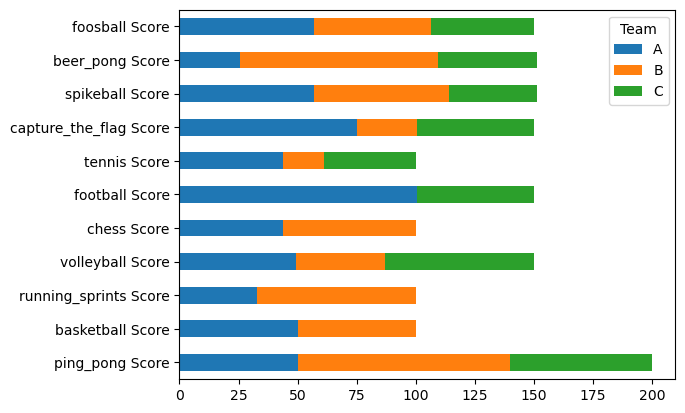

In [72]:
match_df = hf.turn_series_list_to_dataframe([m.as_series for m in hf.ALL_MATCHES])
from random import choices, seed
seed(42)
match_df["subteam_a"] = match_df["team_a"]
match_df["subteam_b"] = match_df["team_b"]
match_df["team_a"] = match_df["team_a_key"].str.slice(0, 1)
match_df["team_b"] = match_df["team_b_key"].str.slice(0, 1)
match_df["winner"] = choices(["A", "B", "C", "AB", "AC", "BC"], k=len(match_df))

def _calc_score_for_team(match_df: pd.DataFrame, team_letter: str, sport: str) -> float:
    assert sport in hf.SPORTS_LIST
    assert team_letter in "ABC"
    sport_df = match_df[match_df["sport"] == sport]
    num_won = np.sum(sport_df["winner"] == team_letter)
    num_tied = np.sum(sport_df["winner"].apply(lambda x: len(x) > 1 and team_letter in x))
    return num_won + 0.5 * num_tied

sport_nums = {sport: [_calc_score_for_team(match_df, team, sport) for team in "ABC"] for sport in hf.SPORTS_LIST}
sport_nums["Team"] = ["A", "B", "C"]
df = pd.DataFrame(sport_nums).set_index("Team")
for i, sport in enumerate(hf.SPORTS_LIST):
    result_perc = np.round(df[sport]/df[sport].sum() * 100, 0)*hf.SPORTS_EVENTS[sport].point_weight_factor
    colname = f"{sport} Score"
    df.insert(i*2+1, colname, result_perc)
    # df[f"{sport}_perc"] = result_perc
    # df = df.drop(sport, axis=1)
score_df = df[[col for col in df.columns if "Score" in col]].copy()
# df["Weight"] = df.index.map(lambda x: hf.SPORTS_EVENTS[x.split()[0]].point_weight_factor if x.split()[0] in hf.SPORTS_EVENTS else 0)
# df = df.T
# for sport in hf.SPORTS_LIST:
#     col = sport + " Score"
#     df[col] = df[col].astype(int)
# match_df[match_df["sport"] == "basketball"]
from matplotlib.axes import Axes
ax: Axes
fig, ax = plt.subplots()

score_df.T.plot.barh(ax=ax, stacked=True)
score_df["Total Points"] = score_df.sum(axis=1)


## Changing match locations

For some matches, it might make sense to move them around if they are back-to-back, but currently scheduled at different courts.

In [90]:

def change_match_location(match_key: str, new_loc: str):
    new_loc = str(new_loc)
    matches = hf.get_match_df().set_index("full_key", drop=False)
    match_to_change = matches.loc[match_key]
    old_loc = match_to_change["location"]
    if old_loc == new_loc:
        print("Skipped moving match as it was already at new location.")
        return
    # Find the other match at the location we want to switch to:
    other_match = matches[(matches["location"] == new_loc) & (matches["start"] == match_to_change["start"]) & (matches["sport"] == match_to_change["sport"])]
    matches.loc[match_key, "location"] = new_loc
    print(f"Moved {match_key} from loc {old_loc} to {new_loc}.")
    if len(other_match) == 0:
        return
    matches.loc[other_match.iloc[0]["full_key"], "location"] = old_loc
    print(f"To account for this, moved {other_match.iloc[0]["full_key"]} from {new_loc} to {old_loc}.")
    write_match_backup_from_df(matches, True)

# change_match_location("beer_pongA: 3B: 2", "2")
change_match_location("ping_pongB: 12C: 04", "1")

matches = hf.get_matches()
# Filter for all combinations that happen back-to-back:
back_to_back = [comb for comb in combinations(matches, 2) if (comb[0].end == comb[1].start) and (len(set(comb[0].involved_players).intersection(comb[1].involved_players))>0)]
# filter away sports where this isn't relevant
back_to_back = [comb for comb in back_to_back if comb[0].sport not in ["basketball", "chess", "tennis", "football", "capture_the_flag"]]
# Filter away combinations where the locations already match:
back_to_back = [comb for comb in back_to_back if comb[0].location != comb[1].location]
match_keys = [str((comb[0].match_key, comb[0].location, comb[1].match_key, comb[1].location)) for comb in back_to_back]
print("\n".join(match_keys))
match_df = hf.get_match_df().set_index("full_key", drop=False)
match_df[match_df["sport"] == "ping_pong"].loc[[x.match_key for comb in back_to_back for x in comb]]
# change_match_location('spikeballC: 1A: 1', '1')
# print(back_to_back)


Moved ping_pongB: 12C: 04 from loc 3 to 1.
To account for this, moved ping_pongB: 08C: 09 from 1 to 3.
('ping_pongB: 01C: 13', '1', 'ping_pongA: 13B: 01', '3')


,sport,team_a,team_b,location,day,time,result,winner,start,duration,team_a_key,team_b_key,full_key
full_key,,,,,,,,,,,,,
ping_pongB: 01C: 13,ping_pong,B: Real Mouse,C: Clever Wombat,1,Tuesday,19:45,NaN,NaN,2024-04-30 19:45:00,1800,B: 01,C: 13,ping_pongB: 01C: 13
ping_pongA: 13B: 01,ping_pong,A: Dishonest Fangtooth,B: Real Mouse,3,Tuesday,20:15,NaN,NaN,2024-04-30 20:15:00,1800,A: 13,B: 01,ping_pongA: 13B: 01
